In [1]:
#Dependencies
import numpy as np, pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
%matplotlib inline
import warnings

Read dataset.

In [2]:
train = pd.read_csv('house_prices_train.csv')
test = pd.read_csv('house_prices_test.csv')
sample = pd.read_csv('house_prices_sample_solution.csv')

In [3]:
train.head()

,ID,Bathrooms,Bedrooms,Erf Size,Garages,Listing Date,Price,Type of Property,Location
0,1003,4.0,4.0,NaN,2.0,2019-10-28,4299000.0,House,"lat: 51.5073509,long: -0.1277583"
1,1011,2.0,3.0,1 733 m²,2.0,2019-06-05,2800000.0,House,"lat: 51.5073509,long: -0.1277583"
2,1016,2.0,3.0,987 m²,1.0,2019-10-31,980000.0,House,"lat: 51.5073509,long: -0.1277583"
3,1019,2.0,3.0,1 539 m²,2.0,2019-10-14,1795000.0,House,"lat: 51.5073509,long: -0.1277583"
4,1029,2.0,3.0,70 m²,NaN,2019-10-02,837780.0,House,"lat: 51.5073509,long: -0.1277583"


In [4]:
test.shape, train.shape

((150, 8), (738, 9))

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 738 entries, 0 to 737
Data columns (total 9 columns):
ID                  738 non-null int64
Bathrooms           636 non-null float64
Bedrooms            717 non-null float64
Erf Size            577 non-null object
Garages             450 non-null float64
Listing Date        738 non-null object
Price               736 non-null float64
Type of Property    738 non-null object
Location            738 non-null object
dtypes: float64(4), int64(1), object(4)
memory usage: 52.0+ KB


In [6]:
train.describe()

,ID,Bathrooms,Bedrooms,Garages,Price
count,738.000000,636.000000,717.000000,450.000000,7.360000e+02
mean,2478.681572,2.099057,3.189679,2.086667,2.031752e+06
std,869.557030,0.990315,1.219146,0.966729,2.206027e+06
min,1.000000,1.000000,1.000000,1.000000,9.000000e+04
25%,1734.750000,2.000000,2.000000,2.000000,8.800000e+05
50%,2465.500000,2.000000,3.000000,2.000000,1.400000e+06
75%,3215.750000,2.000000,4.000000,2.000000,2.346250e+06
max,3999.000000,8.000000,16.000000,8.000000,3.000000e+07


Append Test set to Train set for preprocessing.

In [7]:
result = train.append([test],ignore_index=True)

C:\Users\Marcus\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


# Preprocessing

In [8]:
result.shape

(888, 9)

In [9]:
result.tail()

,Bathrooms,Bedrooms,Erf Size,Garages,ID,Listing Date,Location,Price,Type of Property
883,1.0,2.0,2 000 m²,NaN,4572,2019-07-02,"lat: 51.5073509,long: -0.1277583",NaN,House
884,2.0,4.0,NaN,2.0,4575,2017-10-17,"lat: 51.5073509,long: -0.1277583",NaN,House
885,1.0,2.0,NaN,NaN,4580,2017-11-29,"lat: 51.5073509,long: -0.1277583",NaN,Townhouse
886,2.0,3.0,1 016 m²,2.0,4592,2019-04-25,"lat: 51.5073509,long: -0.1277583",NaN,House
887,2.0,3.0,995 m²,2.0,4595,2018-04-23,"lat: 51.5073509,long: -0.1277583",NaN,House


Change data types to correct format for EDA purposes.

In [10]:
result['Listing Date']=pd.to_datetime(result['Listing Date'])
result['year_date']=result['Listing Date'].dt.year
result['Month_date']=result['Listing Date'].dt.month
result['ID']=result['ID'].astype(str)

Drop 'Listing Date' as we have created 2 columns 'year_date' and 'Month_date' as the regression algorithm would not be able to read dates.

In [11]:
result.drop('Listing Date',inplace=True,axis=1)

Extract digits from input in ERF Size meter square.

In [12]:
result['Erf Size'] = result['Erf Size'].astype(str)
result['Erf Size']=result['Erf Size'].apply(lambda x : [int(s) for s in x.split() if s.isdigit()])

In [13]:
#Remove square brackets
def listToStringWithoutBrackets(list1):
    return str(list1).replace('[','').replace(']','')
result['Erf Size'] =result['Erf Size'].apply(listToStringWithoutBrackets)

In [14]:
#Remove commas from input
def removecoma(list1):
    return str(list1).replace(',','')
result['Erf Size'] =result['Erf Size'].apply(removecoma)

In [15]:
#Remove spaces from input
def spces(list1):
    return str(list1).replace(" ", "")
result['Erf Size'] =result['Erf Size'].apply(spces)

In [16]:
#Fill blank spaces with Nan values
result['Erf Size']=result['Erf Size'].replace(r'', np.NaN)

In [17]:
#Change data type to float
result['Erf Size']=result['Erf Size'].astype(float)

In [18]:
result['Erf Size'] = pd.to_numeric(result['Erf Size'], errors='coerce')

In [19]:
result['Location'].nunique()

1

In [20]:
#Drop Location as there is only one value and wont affect the prediction
result=result.drop('Location',axis=1)

Split dataset into train and test set.

In [21]:
result_train=result[:train.shape[0]]
result_test=result[train.shape[0]:]
result_train.shape, result_test.shape

((738, 9), (150, 9))

In [22]:
result_test.head()

,Bathrooms,Bedrooms,Erf Size,Garages,ID,Price,Type of Property,year_date,Month_date
738,2.0,2.0,70.0,NaN,4001,NaN,Apartment / Flat,2019,6
739,1.0,2.0,91.0,NaN,4002,NaN,Townhouse,2019,2
740,2.0,2.0,72.0,NaN,4003,NaN,Townhouse,2019,5
741,4.0,4.0,265.0,2.0,4007,NaN,House,2019,2
742,2.0,3.0,213.0,2.0,4016,NaN,Townhouse,2018,8


30000000.0


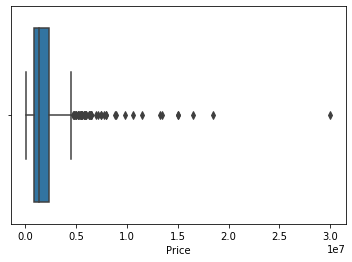

In [23]:
sns.boxplot(result_train['Price'])
print(result_train['Price'].max())

In [24]:
#Remove outliers as the model would be bais to the outliers
i=result_train[result_train['Price'] == 30000000.0].index
result_train.drop(i,inplace=True)

C:\Users\Marcus\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [25]:
result_train.Price.max()

18500000.0

In [26]:
result_train.head()

,Bathrooms,Bedrooms,Erf Size,Garages,ID,Price,Type of Property,year_date,Month_date
0,4.0,4.0,NaN,2.0,1003,4299000.0,House,2019,10
1,2.0,3.0,1733.0,2.0,1011,2800000.0,House,2019,6
2,2.0,3.0,987.0,1.0,1016,980000.0,House,2019,10
3,2.0,3.0,1539.0,2.0,1019,1795000.0,House,2019,10
4,2.0,3.0,70.0,NaN,1029,837780.0,House,2019,10


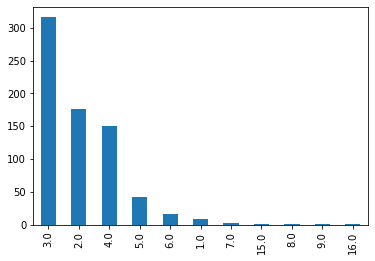

In [27]:
#Remove outliers in the Bedroom attribute as the model might be bais towards them 
result_train['Bedrooms'].value_counts().plot(kind='bar')

In [28]:
bed_outlier=result_train[(result_train['Bedrooms'] == 15.0) | (result_train['Bedrooms'] == 16.0) | (result_train['Bedrooms'] == 8.0) | (result_train['Bedrooms'] == 9.0)].index
result_train.drop(bed_outlier,inplace=True)

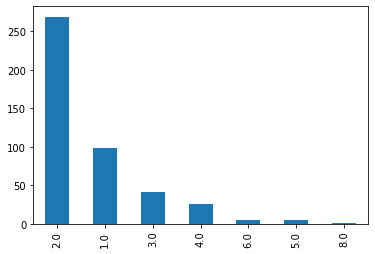

In [29]:
#Remove outliers in the Garages attribute as the model might be bais towards them 
result_train['Garages'].value_counts().plot(kind='bar')

In [30]:
garage_outlier=result_train[(result_train['Garages'] == 7.0) | (result_train['Garages'] == 8.0)].index
result_train.drop(garage_outlier,inplace=True)

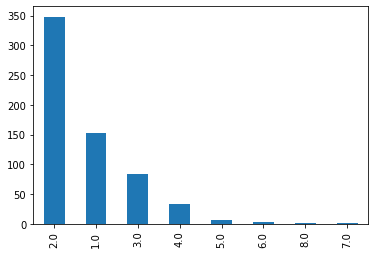

In [31]:
#Remove outliers in the Bathrooms attribute as the model might be bais towards them 
result_train['Bathrooms'].value_counts().plot(kind='bar')

In [32]:
bath_outlier=result_train[(result_train['Bathrooms'] == 7.0) | (result_train['Bathrooms'] == 8.0)].index
result_train.drop(bath_outlier,inplace=True)

In [33]:
result_train.head()

,Bathrooms,Bedrooms,Erf Size,Garages,ID,Price,Type of Property,year_date,Month_date
0,4.0,4.0,NaN,2.0,1003,4299000.0,House,2019,10
1,2.0,3.0,1733.0,2.0,1011,2800000.0,House,2019,6
2,2.0,3.0,987.0,1.0,1016,980000.0,House,2019,10
3,2.0,3.0,1539.0,2.0,1019,1795000.0,House,2019,10
4,2.0,3.0,70.0,NaN,1029,837780.0,House,2019,10


# EDA

In [34]:
result_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 737
Data columns (total 9 columns):
Bathrooms           628 non-null float64
Bedrooms            709 non-null float64
Erf Size            570 non-null float64
Garages             444 non-null float64
ID                  730 non-null object
Price               728 non-null float64
Type of Property    730 non-null object
year_date           730 non-null int64
Month_date          730 non-null int64
dtypes: float64(5), int64(2), object(2)
memory usage: 57.0+ KB


In [35]:
result_train.describe()

,Bathrooms,Bedrooms,Erf Size,Garages,Price,year_date,Month_date
count,628.000000,709.000000,570.000000,444.000000,7.280000e+02,730.000000,730.000000
mean,2.052548,3.122708,878.163158,2.058559,1.982040e+06,2018.919178,7.658904
std,0.876110,0.965744,4786.222858,0.899558,1.952051e+06,0.347895,2.162807
min,1.000000,1.000000,1.000000,1.000000,9.000000e+04,2014.000000,1.000000
25%,2.000000,2.000000,79.250000,2.000000,8.797500e+05,2019.000000,6.000000
50%,2.000000,3.000000,188.000000,2.000000,1.399000e+06,2019.000000,8.000000
75%,2.000000,4.000000,681.750000,2.000000,2.296000e+06,2019.000000,9.000000
max,6.000000,6.000000,89979.000000,6.000000,1.850000e+07,2019.000000,12.000000


In [36]:
result_train.isnull().sum()

Bathrooms           102
Bedrooms             21
Erf Size            160
Garages             286
ID                    0
Price                 2
Type of Property      0
year_date             0
Month_date            0
dtype: int64

In [37]:
result_test.isnull().sum()

Bathrooms            31
Bedrooms             11
Erf Size             70
Garages              77
ID                    0
Price               150
Type of Property      0
year_date             0
Month_date            0
dtype: int64

Below we can see which attributes has a stronger correlation with the dependant variable - Price

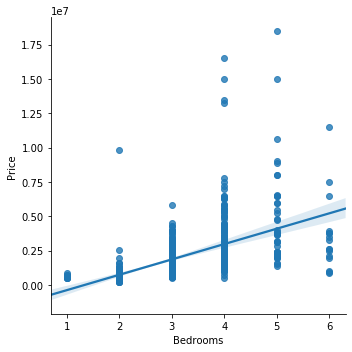

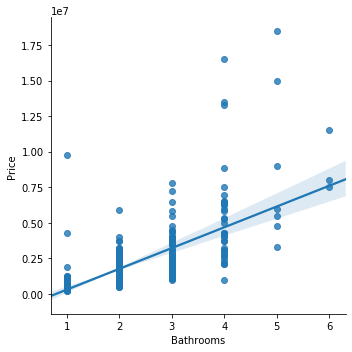

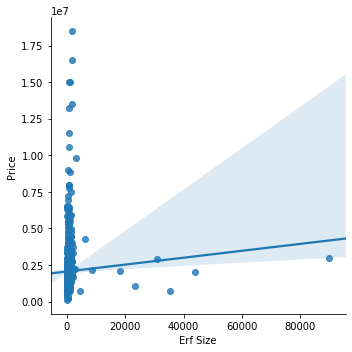

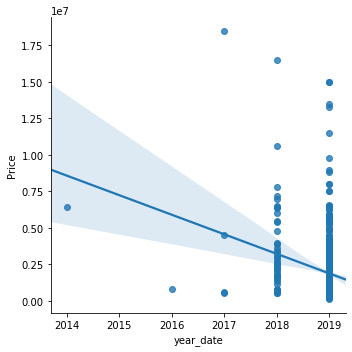

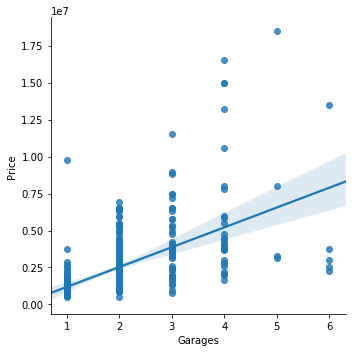

In [38]:
sns.lmplot('Bedrooms','Price',data=result_train)
sns.lmplot('Bathrooms','Price',data=result_train)
sns.lmplot('Erf Size','Price',data=result_train)
sns.lmplot('year_date','Price',data=result_train)
sns.lmplot('Garages','Price',data=result_train)

Distributions plots of independant variables.

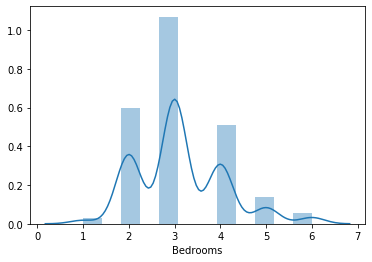

In [39]:
sns.distplot(result_train['Bedrooms'].dropna())

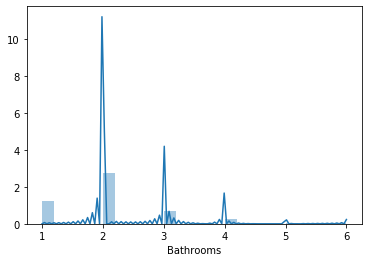

In [40]:
sns.distplot(result_train['Bathrooms'].dropna())

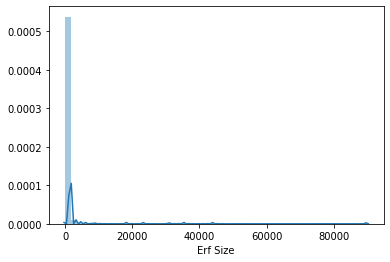

In [41]:
sns.distplot(result_train['Erf Size'].dropna())

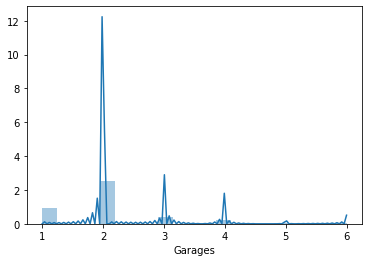

In [42]:
sns.distplot(result_train['Garages'].dropna())

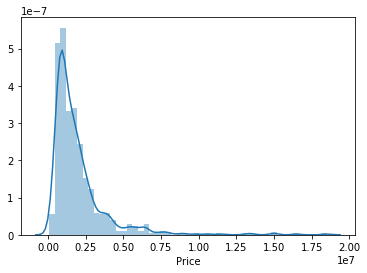

In [43]:
sns.distplot(result_train['Price'].dropna())

In [44]:
y = result_train['Price']

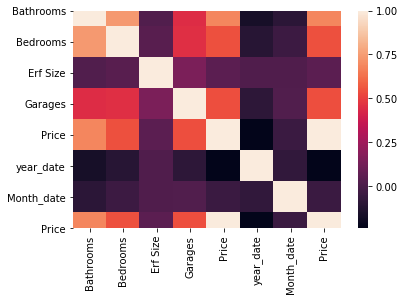

In [45]:
corr= pd.concat([result_train,y],axis=1).corr()
sns.heatmap(corr)

In [87]:
y

0      4299000.0
1      2800000.0
2       980000.0
3      1795000.0
4       837780.0
         ...    
733     880000.0
734    2750000.0
735    1895000.0
736     230000.0
737    1850000.0
Name: Price, Length: 730, dtype: float64

# Impute Nan values

In [46]:
result_train.isnull().sum()

Bathrooms           102
Bedrooms             21
Erf Size            160
Garages             286
ID                    0
Price                 2
Type of Property      0
year_date             0
Month_date            0
dtype: int64

In [47]:
result_test.isnull().sum()

Bathrooms            31
Bedrooms             11
Erf Size             70
Garages              77
ID                    0
Price               150
Type of Property      0
year_date             0
Month_date            0
dtype: int64

In [48]:
#Train Set
#For attribute Garage impute the median as it has a positive skew 
result_train['Garages']=result_train['Garages'].fillna(result_train['Garages'].mode()[0])
#For attribute Erf Size impute the mean as it has a normal distribution.
result_train['Erf Size']=result_train['Erf Size'].fillna(result_train['Erf Size'].median())
#For attribute Bedrooms impute the mean as it has a normal distribution.
result_train['Bedrooms']=result_train['Bedrooms'].fillna(int(result_train['Bedrooms'].mean()))
#For attribute Bathrooms impute the median as it has a positive skew.
result_train['Bathrooms']=result_train['Bathrooms'].fillna(int(result['Bathrooms'].median()))
#For attribute Price impute the median as it has a positive skew.
result_train['Price']=result_train['Price'].fillna(result['Bathrooms'].median())

C:\Users\Marcus\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Marcus\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Marcus\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [49]:
#Test Set
#For attribute Garage impute the median as it has a positive skew 
result_test['Garages']=result_test['Garages'].fillna(result_train['Garages'].mode()[0])
#For attribute Erf Size impute the mean as it has a normal distribution.
result_test['Erf Size']=result_test['Erf Size'].fillna(result_train['Erf Size'].median())
#For attribute Bedrooms impute the mean as it has a normal distribution.
result_test['Bedrooms']=result_test['Bedrooms'].fillna(int(result_train['Bedrooms'].mean()))
#For attribute Bathrooms impute the median as it has a positive skew.
result_test['Bathrooms']=result_test['Bathrooms'].fillna(int(result['Bathrooms'].median()))

C:\Users\Marcus\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Marcus\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Marcus\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [50]:
#Drop Price on Test Set
result_test.drop('Price',axis=1,inplace=True)

In [51]:
result_train.isnull().sum()

Bathrooms           0
Bedrooms            0
Erf Size            0
Garages             0
ID                  0
Price               0
Type of Property    0
year_date           0
Month_date          0
dtype: int64

In [52]:
#Remove dependant variable
result_train=result_train.drop(['Price'],axis=1)
#train=train.reset_index()

In [53]:
y.shape

(730,)

In [54]:
result_test.head()

,Bathrooms,Bedrooms,Erf Size,Garages,ID,Type of Property,year_date,Month_date
738,2.0,2.0,70.0,2.0,4001,Apartment / Flat,2019,6
739,1.0,2.0,91.0,2.0,4002,Townhouse,2019,2
740,2.0,2.0,72.0,2.0,4003,Townhouse,2019,5
741,4.0,4.0,265.0,2.0,4007,House,2019,2
742,2.0,3.0,213.0,2.0,4016,Townhouse,2018,8


Create dummies variables for catagorical attributes.

In [55]:
x_train_dummies = pd.get_dummies(result_train['Type of Property'], drop_first=True)
x_train_num=pd.concat([result_train,x_train_dummies],axis=1)
x_train_num.drop('Type of Property',axis=1,inplace=True)
x_test_dummies = pd.get_dummies(result_test['Type of Property'], drop_first=True)
x_test_num=pd.concat([result_test,x_test_dummies],axis=1)
x_test_num.drop('Type of Property',axis=1,inplace=True)

In [56]:
x_train_num.shape, y.shape,x_test_num.shape

((730, 9), (730,), (150, 9))

In [57]:
ID_test= x_test_num['ID']
x_test_num.drop('ID',axis=1,inplace=True)
ID_train=x_train_num['ID']
x_train_num.drop('ID',axis=1,inplace=True)

In [58]:
ID_train.shape,ID_test.shape

((730,), (150,))

In [59]:
x_train_num.head()

,Bathrooms,Bedrooms,Erf Size,Garages,year_date,Month_date,House,Townhouse
0,4.0,4.0,188.0,2.0,2019,10,1,0
1,2.0,3.0,1733.0,2.0,2019,6,1,0
2,2.0,3.0,987.0,1.0,2019,10,1,0
3,2.0,3.0,1539.0,2.0,2019,10,1,0
4,2.0,3.0,70.0,2.0,2019,10,1,0


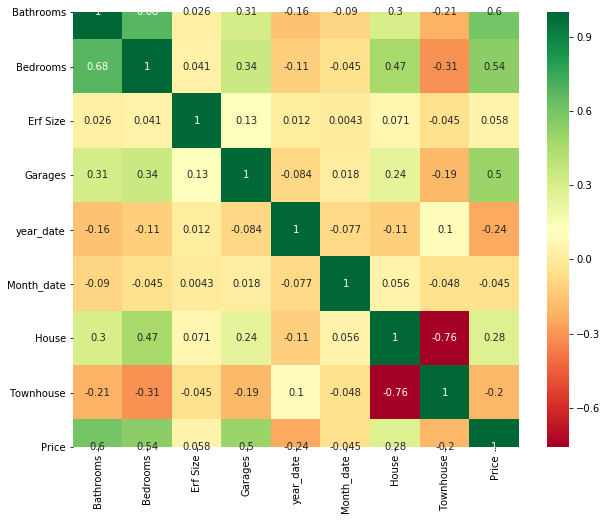

In [60]:
plt.figure(figsize=(10,8))
corr= pd.concat([x_train_num,y],axis=1).corr()
sns.heatmap(corr,annot=True,cmap='RdYlGn')

In [61]:
#Reduce the dimention
x_train_num = x_train_num[['Bedrooms','Bathrooms','Garages','House']]
x_test_num = x_test_num[['Bedrooms','Bathrooms','Garages','House']]

In [62]:
x_test_num.head()

,Bedrooms,Bathrooms,Garages,House
738,2.0,2.0,2.0,0
739,2.0,1.0,2.0,0
740,2.0,2.0,2.0,0
741,4.0,4.0,2.0,1
742,3.0,2.0,2.0,0


# Training Model

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [64]:
X_train, X_test, y_train, y_test = train_test_split(x_train_num, y, random_state=11)

sc = StandardScaler()
sc.fit(X_train)
X_train_scaled = sc.transform(X_train)
X_test_scaled = sc.transform(X_test)
#X_blind_scaled = sc.transform(test_num)

X_train_scaled.shape, X_test_scaled.shape

((547, 4), (183, 4))

In [65]:
#Fit linear regression to data
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

X_train_pred = linreg.predict(X_train_scaled)
X_test_pred = linreg.predict(X_test_scaled)


In [66]:
#Evaluate train set
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, X_train_pred)))
print('RMSE:', np.sqrt(metrics.r2_score(y_train, X_train_pred)))
#Evaluate test set
print('RMSE pred:', np.sqrt(metrics.mean_squared_error(y_test, X_test_pred)))
print('R_squared pred:', metrics.r2_score(y_test, X_test_pred))

RMSE: 1379719.2749692944
RMSE: 0.7033138395443354
RMSE pred: 1468138.828237746
R_squared pred: 0.45005391978826825


A linear Regression model predicts well on the training data but not so well on the test data.

In [67]:
for i in [0.0001, 0.001, 0.01, 0.1, 1]:
    rr = Ridge(alpha=10)
    rr.fit(X_train_scaled, y_train)
    
    rr_X_train_pred = rr.predict(X_train_scaled)
    rr_X_test_pred = rr.predict(X_test_scaled)
    
    print('alpha: ', i)
    
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, rr_X_train_pred)))
    print('RMSE:', np.sqrt(metrics.r2_score(y_train, rr_X_train_pred)))
    
    print('RMSE pred:', np.sqrt(metrics.mean_squared_error(y_test, rr_X_test_pred)))
    print('R_squared pred:', metrics.r2_score(y_test, rr_X_test_pred))
    
    print('\n')

alpha:  0.0001
RMSE: 1379841.4629586954
RMSE: 0.7032502011130068
RMSE pred: 1465774.10755728
R_squared pred: 0.45182408145974673


alpha:  0.001
RMSE: 1379841.4629586954
RMSE: 0.7032502011130068
RMSE pred: 1465774.10755728
R_squared pred: 0.45182408145974673


alpha:  0.01
RMSE: 1379841.4629586954
RMSE: 0.7032502011130068
RMSE pred: 1465774.10755728
R_squared pred: 0.45182408145974673


alpha:  0.1
RMSE: 1379841.4629586954
RMSE: 0.7032502011130068
RMSE pred: 1465774.10755728
R_squared pred: 0.45182408145974673


alpha:  1
RMSE: 1379841.4629586954
RMSE: 0.7032502011130068
RMSE pred: 1465774.10755728
R_squared pred: 0.45182408145974673




A Ridge Regression model does not differ much from the linear regression irrespective of the alpha values that differ. It predicts well on the training data but not so well on the test data.

In [68]:
#Evaluate train set
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, rr_X_train_pred)))
print('RMSE:', np.sqrt(metrics.r2_score(y_train, rr_X_train_pred)))
#Evaluate test set
print('RMSE pred:', np.sqrt(metrics.mean_squared_error(y_test, rr_X_test_pred)))
print('R_squared pred:', metrics.r2_score(y_test, rr_X_test_pred))

RMSE: 1379841.4629586954
RMSE: 0.7032502011130068
RMSE pred: 1465774.10755728
R_squared pred: 0.45182408145974673


In [69]:
for i in [0.0001, 0.001, 0.01, 0.1, 1]:
    lass = Lasso(alpha=i)
    lass.fit(X_train_scaled, y_train)

    las_X_train_pred = lass.predict(X_train_scaled)
    las_X_test_pred = lass.predict(X_test_scaled)
    
    print('alpha:', i)
    
    #Evaluate train set
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, las_X_train_pred)))
    print('RMSE:', np.sqrt(metrics.r2_score(y_train, las_X_train_pred)))
    
    #Evaluate test set
    print('RMSE pred:', np.sqrt(metrics.mean_squared_error(y_test, las_X_test_pred)))
    print('R_squared pred:', metrics.r2_score(y_test, las_X_test_pred))
    

    print('\n')

alpha: 0.0001
RMSE: 1379719.2749692944
RMSE: 0.7033138395443354
RMSE pred: 1468138.828212434
R_squared pred: 0.4500539198072312


alpha: 0.001
RMSE: 1379719.2749692944
RMSE: 0.7033138395443354
RMSE pred: 1468138.8279962966
R_squared pred: 0.4500539199691558


alpha: 0.01
RMSE: 1379719.2749692947
RMSE: 0.7033138395443354
RMSE pred: 1468138.8259325682
R_squared pred: 0.4500539215152485


alpha: 0.1
RMSE: 1379719.2749693054
RMSE: 0.7033138395443297
RMSE pred: 1468138.8062101377
R_squared pred: 0.45005393629079016


alpha: 1
RMSE: 1379719.2749702947
RMSE: 0.7033138395438145
RMSE pred: 1468138.6175599855
R_squared pred: 0.4500540776226609




A Lasso Regression model does not differ much from the linear regression as well, irrespective of the alpha values that differ. It predicts well on the training data but not so well on the test data.

In [70]:
rfr= RandomForestRegressor(n_estimators=100)
rfr.fit(X_train_scaled, y_train)

random_X_train_pred = linreg.predict(X_train_scaled)
random_X_test_pred = linreg.predict(X_test_scaled)
#Evaluate train set
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, random_X_train_pred)))
print('RMSE:', np.sqrt(metrics.r2_score(y_train, random_X_train_pred)))
#Evaluate test set
print('RMSE pred:', np.sqrt(metrics.mean_squared_error(y_test, random_X_test_pred)))
print('R_squared pred:', metrics.r2_score(y_test, random_X_test_pred))

RMSE: 1379719.2749692944
RMSE: 0.7033138395443354
RMSE pred: 1468138.828237746
R_squared pred: 0.45005391978826825


Not much of an improvement with a Randomforest Regressor

In [71]:
#conda install -c anaconda py-xgboost

In [72]:
#conda install -c anaconda py-xgboost

In [73]:
import xgboost

In [74]:
model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 

In [75]:
model.fit(X_train_scaled, y_train)

C:\Users\Marcus\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:28:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0,
             importance_type='gain', learning_rate=0.07, max_delta_step=0,
             max_depth=3, min_child_weight=1.5, missing=None,
             n_estimators=10000, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0.75, reg_lambda=0.45,
             scale_pos_weight=1, seed=42, silent=None, subsample=0.6,
             verbosity=1)

In [76]:
#pred=model.predict(X_train_scaled)
xg_X_train_pred = model.predict(X_train_scaled)
xg_X_test_pred = model.predict(X_test_scaled)

In [77]:
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, xg_X_train_pred)))
print('RMSE:', np.sqrt(metrics.r2_score(y_train, xg_X_train_pred)))
#Evaluate test set
print('RMSE pred:', np.sqrt(metrics.mean_squared_error(y_test, xg_X_test_pred)))
print('R_squared pred:', metrics.r2_score(y_test, xg_X_test_pred))

RMSE: 1209018.318574564
RMSE: 0.7822788559353046
RMSE pred: 1524294.8360620858
R_squared pred: 0.4071786743465694


Lasso algorithm gives us the highest R^2.

In [78]:
sc.fit(x_test_num)
tested_scaled = sc.transform(x_test_num)

In [79]:
test_predictions = model.predict(tested_scaled)
test_predictions.shape

(150,)

In [134]:
test_predictions = pd.DataFrame(test_predictions)
ID_test = pd.DataFrame(ID_test).reset_index()

In [141]:
ID_test = ID_test.drop(['index'],axis=1)

In [145]:
ID_test.set_index('level_0',inplace=True)

In [152]:
submissions = pd.concat([ID_test,test_predictions],axis=1)
submissions.columns=[['ID','Predicts']]

ID                 4001
Predicts    1.07191e+06
Name: 0, dtype: object

In [154]:
submissions.shape

(150, 2)